# Convert Geopandas GeoSeries to spherical harmonics 
Author: R. Rietbroek Jan 2025 (r.rietbroek@utwente.nl)*

Often, geographical geometry objects are needed as masks (1 inside,0 outside) expressed in the spherical harmonic domain. This notebook shows how a geopandas Geoseries, containing polygon masks or points can be converted to spherical harmonic coefficients

## 1. Preparations

In [1]:
#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import os
import shxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import geopandas as gpd
from shapely import Point

In [16]:
#set the maximum desired degree of the output spherical harmonics
nmax=120

/home/roelof/cld_UTwente/Soft/shxarray-git/src/shxarray/core/xr_accessor.py:18: AccessorRegistrationWarning: registration of accessor <class 'shxarray.core.xr_accessor.SHDaAccessor'> under name 'sh' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor("sh")
/home/roelof/cld_UTwente/Soft/shxarray-git/src/shxarray/core/xr_accessor.py:280: AccessorRegistrationWarning: registration of accessor <class 'shxarray.core.xr_accessor.SHDsAccessor'> under name 'sh' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  def synthesis(self,lon=None, lat=None,engine="shlib",**kwargs):


## 2. Get a set of Antartic grounded drainage basins (as polygons) to use as continental loads

Note that in this case we load the geometries from a [geoslurp database](https://geoslurp.wobbly.earth/en/latest/), but the example can be easily modified to load shapes from e.g. geopackage files.

Text(0.5, 1.0, 'Antarctic grounded drainage basins')

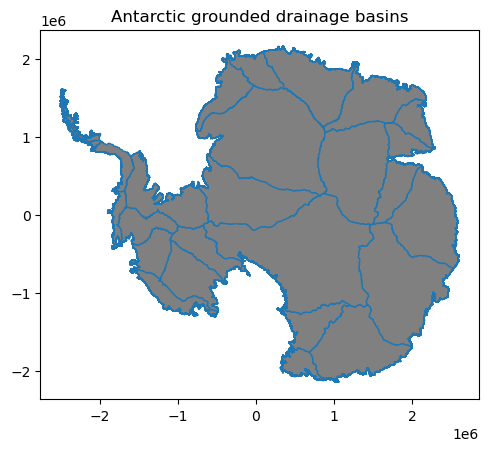

In [4]:
# In this example we're loading the drainage basin outlines froma geoslurp database
# The original datasources can be found at https://earth.gsfc.nasa.gov/cryo/data/polar-altimetry/antarctic-and-greenland-drainage-systems
from geoslurp.manager import GeoslurpManager
import geoslurp.tools.pandas  
import pandas as pd
gsman=GeoslurpManager(dbalias="tunnelmarge")
tname="cryo.antarc_ddiv_icesat_grnd"

# One can populate the database like this:
#dsant=gsman.dataset(tname)
#dsant.pull()
#dsant.register()

#load the polygons from the databse in a geopandas dataframe NOTE: convert to polar stereographic projection because the polgyon contains the south Pole
#And this projection is needed when converting to spherical harmonics
dfant=pd.DataFrame.gslrp.load(gsman.conn,f"SELECT basinid,ST_transform(geom::geometry,3031) as geometry FROM {tname}")
# quick plot of the drainage basin outlines
ax=dfant.plot(edgecolor="tab:blue",facecolor="grey")
ax.set_title("Antarctic grounded drainage basins")

## 3 Convert the drainage outline to spherical harmonics of the desired degrees
We take the column `basinid` as an axiliary coordinate to indicate the original geometries present


In [11]:
dantsh=xr.DataArray.sh.from_geoseries(dfant.geometry,nmax,auxcoord=dfant.basinid,engine="shtns")
dantsh.name='ant_div'
display(dantsh)

#optionally save to disk
fout=f"data/antarc_ddiv_icesat_grnd_n{nmax}.nc"
# dantsh.reset_index('nm').to_netcdf(fout)

[SHTns 3.7.3] built Jan 17 2025, 23:35:53, id: v3.7-9-gbfb51b8*,avx2,ishioka,openmp,cuda


shxarray-INFO: Masking and gridding polygons
shxarray-INFO: Applying SH analysis


<xarray.DataArray 'ant_div' (basinid: 26, nm: 14641)> Size: 3MB
array([[ 9.40267020e-04, -3.05624425e-04, -1.59546257e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.54626069e-03, -4.34739860e-05, -2.67059892e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.05559875e-03,  1.44490204e-04, -5.21075910e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.07448024e-04, -1.00811097e-04, -3.42265171e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.83668038e-05, -3.63363264e-05, -9.28618692e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.85327017e-05, -4.81902117e-05, -1.24477510e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(26, 14641))
Coordinates:
  * nm       (nm) object 117kB MultiIndex
  * n        (nm) int64 117kB 0 1 1 1 2 2 2 2 ... 120 120 120 120 120 120 120
  * m        (nm) int64 117kB 0 -1 0 1 -2 -1 0 1 ... 114 115 116 117 118 119 120
  * basinid  (basinid) float64 208B 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0
Attributes:
    Conventions:  CF-1.8
    source:       shxarray-1.2.1.dev17+ged5d445.d20250123 <https://github.com...
    contact:      Roelof Rietbroek <r.rietbroek@utwente.nl>
    institution:  ITC Faculty of Geo-Information Science and Earth Observatio...
    comments:     Used backend: SHTns High performance Spherical Harmonic Tra...
    history:      Analysis operation

## 4 Check if the intermediate drainage basin results made sense
A spatially discontinuous function cannnot be one-to-one mapped to spectrally truncated function, so some Gibb's phenomena is to be expected


Text(0.5, 1.0, 'Antarctic drainage basin 18 from sh nmax=120')

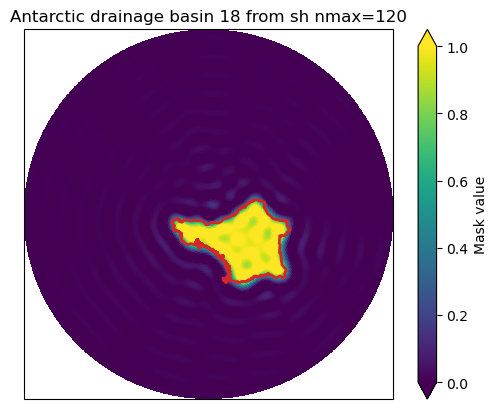

In [12]:
# Sum all spherical harmonic coefficient sets for all basins and grid
import cartopy.crs as ccrs
dres=0.25
basinid=18
# basinid=3
daantgrd=dantsh.sel(basinid=basinid).sh.synthesis(lon=np.arange(-180+dres/2,180,dres),lat=np.arange(-90+dres/2,-60,dres))
daantgrd.name="Mask value"
# daantgrd=daantgrd[daantgrd.lat < -50]
ax = plt.axes(projection=ccrs.SouthPolarStereo())
daantgrd.plot(ax=ax,vmax=1,vmin=0,transform=ccrs.PlateCarree())
ax.add_geometries(dfant[dfant.basinid==basinid].geometry,edgecolor='tab:red',crs=ccrs.SouthPolarStereo(),facecolor="none",lw=2)
plt.title(f"Antarctic drainage basin {basinid} from sh nmax={nmax}")

## 5 What about the conversion of geometry points?
Points can be interpreted as **unit loads, disks or parabolic loads**, before being expanded into spherical harmonic coefficients.
Let's create some randomized points on the sphere first


In [13]:
from random import sample
npoints=100
latrange=180
lonrange=360
discr=0.001245
latpnt=sample(sorted(np.arange(-90,90,discr)),npoints)
lonpnt=sample(sorted(np.arange(-180,180,discr)),npoints)
gspnts=gpd.GeoSeries([Point(x,y) for x,y in zip(lonpnt,latpnt)]).set_crs(ccrs.PlateCarree())

In [14]:
#convert the points to spherical harmonics of disks with spherical radius of 4 degrees
dadskssh=xr.DataArray.sh.from_geoseries(gspnts,nmax,axialtype="disk",psi=4)

#unitload
#daunitsh=xr.DataArray.sh.from_geoseries(gspnts,nmax)

#Parabolic caps
# daparacsh=xr.DataArray.sh.from_geoseries(gspnts,nmax,axialtype="paraboliccap",psi=4)

display(dadskssh)

<xarray.DataArray 'shdisk' (nlonlat: 100, nm: 14641)> Size: 12MB
array([[-7.98018139e-046,  4.68545312e-045,  6.49876794e-044, ...,
        -4.03003727e-045, -5.58969993e-044,  2.70487821e-045],
       [ 1.35493776e-059,  1.09694956e-060,  1.60178764e-059, ...,
         6.97549517e-059,  1.01857573e-057, -2.01777478e-059],
       [ 1.79981953e-078,  6.08291180e-078, -9.19234058e-077, ...,
         4.83598077e-078, -7.30801034e-077, -5.29770319e-079],
       ...,
       [-1.79150622e-116,  3.16292459e-116, -4.89048466e-115, ...,
        -2.72807484e-115,  4.21812401e-114,  2.66646475e-116],
       [-3.53891728e-067,  6.88935952e-066,  1.02217376e-064, ...,
         1.15351689e-066,  1.71147216e-065,  2.09566999e-066],
       [-9.72981424e-034, -5.81789702e-034, -7.46284052e-033, ...,
        -1.60706017e-033, -2.06143795e-032,  1.97184914e-035]],
      shape=(100, 14641))
Coordinates:
  * nm       (nm) object 117kB MultiIndex
  * n        (nm) int32 59kB 120 119 120 118 119 120 ... 118 119 120 119 120 120
  * m        (nm) int32 59kB -120 -119 -119 -118 -118 ... 118 118 119 119 120
    lon      (nlonlat) float64 800B -147.1 145.2 54.89 ... 152.7 -90.08 71.26
    lat      (nlonlat) float64 800B 62.99 69.71 -76.1 ... -83.32 72.38 55.48
    id       (nlonlat) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: nlonlat

## 6 Create a visualization of all the disk loads together

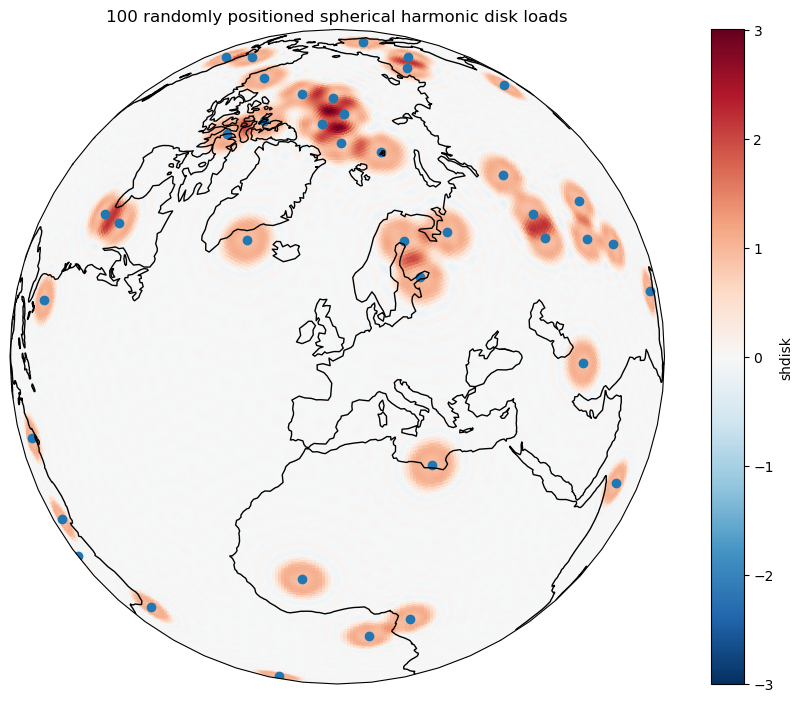

In [15]:

dadsks=dadskssh.sum("nlonlat").sh.synthesis()

proj=ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=50, satellite_height=35785831) 
fig, ax = plt.subplots(subplot_kw={'projection': proj},figsize=(12,8.5))

ax.coastlines()
dadsks.plot(ax=ax,transform=ccrs.PlateCarree())
gspnts.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_title("100 randomly positioned spherical harmonic disk loads")
plt.show()